 <font size="3">Test `TimeseriesExtractor` using the test dataset if not using a Windows machine since pybids is needed. For Windows, this will work if you use [Windows Subsytem for Linux (WSL)](https://code.visualstudio.com/docs/remote/wsl-tutorial) and [open jupyter notebook from the Ubuntu terminal](https://saturncloud.io/blog/how-to-install-jupyter-notebook-in-ubuntu/) or you can use `pip install pybids`
 or `pip install neurocaps[windows]` to install pybids and follow the instructions if you recieve an error message requesting that long path support must be enabled. On Windows, you can enable long path support by right clicking on Windows Powershell, selecting "Run as administer", and pasting the Powershell command found in the official [Microsoft documentation](https://learn.microsoft.com/en-us/windows/win32/fileio/maximum-file-path-limitation?tabs=powershell). </font>

In [1]:
import os, subprocess, sys
import plotly.io as pio

from neurocaps.extraction import TimeseriesExtractor
from neurocaps.analysis import (CAP, merge_dicts, standardize, change_dtype)
import numpy as np, joblib, neurocaps

# To show static plotly images so that they can be displayed on the saved Jupyter notebook on Github
pio.renderers.default = "svg"

parcel_approach = {"Schaefer": {"n_rois": 100}}
#parcel_approach = {"AAL": {"version": "SPM12"}}

ncol = parcel_approach["Schaefer"]["n_rois"] if "Schaefer" in parcel_approach.keys() else 116

try:
    bids_dir = "tests/ds000031_R1.0.4_ses001-022/ds000031_R1.0.4"
    # Get directory used for Github Actions
    if not os.path.isdir(bids_dir):
        neurocaps_demo_dir = "neurocaps_demo"

        os.makedirs(neurocaps_demo_dir, exist_ok=True)

        if sys.platform != "win32":
            cmd = """
                cd neurocaps_demo
                git clone --depth 1 --filter=blob:none --sparse https://github.com/donishadsmith/neurocaps.git
                cd neurocaps
                git sparse-checkout set tests/ds000031_R1.0.4_ses001-022
                """
            os.system(cmd)
        else:
            neurocaps_repo_dir = os.path.join(neurocaps_demo_dir, "neurocaps")

            subprocess.run(
                ["git", "clone", "--depth", "1", "--filter=blob:none", "--sparse",
                "https://github.com/donishadsmith/neurocaps.git"],
                check=True,
                cwd=neurocaps_demo_dir
            )

            subprocess.run(
                ["git", "sparse-checkout", "set", "tests/ds000031_R1.0.4_ses001-022"],
                check=True,
                cwd=neurocaps_repo_dir
            )
            
        bids_dir = "neurocaps_demo/neurocaps/tests/ds000031_R1.0.4_ses001-022/ds000031_R1.0.4"

    # If there are multiple pipelines in derivatives folder or the pipeline is nested, then pipeline_name should be used
    pipeline_name = "fmriprep_1.0.0/fmriprep"

    # Adding an asterisk results in all columns starting with name preceding the asterisk to be extracted for nuisance regression
    confounds=["Cosine*", "aComp*", "Rot*"]

    # Set up signal cleaning parameters
    extractor = TimeseriesExtractor(parcel_approach=parcel_approach,
                                    standardize=False,
                                    use_confounds=True,
                                    detrend=True,
                                    low_pass=0.15,
                                    high_pass=None,
                                    confound_names=confounds,
                                    dummy_scans={"auto": True, "min": 3, "max": 6},
                                    fd_threshold={"threshold": 0.35, "outlier_percentage": 0.30})

    # Perform the timeseries extraction; as of 0.15.2 only one session can be extracted at a time. Use `n_cores` to speed up extraction
    extractor.get_bold(bids_dir=bids_dir,
                       session='002', 
                       runs="001",
                       task="rest", 
                       pipeline_name=pipeline_name, 
                       n_cores=1,
                       tr=1.2,
                       verbose=True)
    
    # Standardize after removal of the outlier volumes; extracted timeseries of all subjects in ``extractor.subject_timeseries``
    subject_timeseries_dict = standardize(subject_timeseries_list=[extractor.subject_timeseries], 
                                          return_dicts = True)

    # Lower the dtype; recommend not going lower than float32, below is an just for example purposes
    subject_timeseries_dict = change_dtype(subject_timeseries_list=[subject_timeseries_dict["dict_0"]], 
                                           dtype="float16")

    # extractor.subject_timeseries is also a setter
    extractor.subject_timeseries = subject_timeseries_dict["dict_0"]

except:
    pass

2024-10-06 16:12:17,852 [WARNING] 'yeo_networks' not specified in `parcel_approach`. Defaulting to 7 networks.
2024-10-06 16:12:17,853 [WARNING] 'resolution_mm' not specified in `parcel_approach`. Defaulting to 1mm.
2024-10-06 16:12:17,856 [INFO] Confound regressors to be used if available: Cosine*, aComp*, Rot*
2024-10-06 16:12:18,401 [INFO] BIDS Layout: ...0.4_ses001-022/ds000031_R1.0.4 | Subjects: 1 | Sessions: 1 | Runs: 1
2024-10-06 16:12:18,456 [INFO] [SUBJECT: 01 | SESSION: 002 | TASK: rest | RUN: 001] Preparing for Timeseries Extraction using [FILE: sub-01_ses-002_task-rest_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz].
2024-10-06 16:12:18,474 [INFO] [SUBJECT: 01 | SESSION: 002 | TASK: rest | RUN: 001] Default dummy scans set by 'min' will be used: 3.
2024-10-06 16:12:18,478 [INFO] [SUBJECT: 01 | SESSION: 002 | TASK: rest | RUN: 001] The following confounds will be used for nuisance regression: Cosine00, Cosine01, Cosine02, Cosine03, Cosine04, Cosine05, Cosine06, a

In [2]:
print(neurocaps.__version__)

0.17.2.post0


<font size="3">Create random data. The `subject_timeseries` property is were the extracted timeseries data is stored and is also a setter. For demonstration purposes, random data is created to use for the `CAP` class to show various configurations and to be able to use the demo on Windows since `TimeseriesExtractor.get_bold()` uses pybids. Additionally, `TimeseriesExtractor` uses default confound names if `use_confounds` is True and `confound_names` is None. By default, `use_confounds` is True and the default or user-specified `confound_names` will print out when True.</font>

In [3]:
extractor = TimeseriesExtractor(parcel_approach=parcel_approach)

extractor.subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(50, ncol) for y in range(1, 4)} for x in range(1, 11)}

2024-10-06 16:12:24,526 [WARNING] 'yeo_networks' not specified in `parcel_approach`. Defaulting to 7 networks.
2024-10-06 16:12:24,527 [WARNING] 'resolution_mm' not specified in `parcel_approach`. Defaulting to 1mm.
2024-10-06 16:12:24,530 [INFO] Confound regressors to be used if available: cosine*, trans_x, trans_x_derivative1, trans_y, trans_y_derivative1, trans_z, trans_z_derivative1, rot_x, rot_x_derivative1, rot_y, rot_y_derivative1, rot_z, rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_02, a_comp_cor_03, a_comp_cor_04, a_comp_cor_05


 <font size="3">Example structure of `subject_timeseries`.</font>

In [4]:
import pprint

subject_timeseries_example = {str(x) : {f"run-{y}": np.random.rand(50, ncol) for y in range(1, 3)} for x in range(1,3)}

pprint.pp(subject_timeseries_example)

{'1': {'run-1': array([[0.25127785, 0.48549567, 0.81318845, ..., 0.05095151, 0.40153012,
        0.87361122],
       [0.97946008, 0.15569855, 0.97834914, ..., 0.11361307, 0.89247311,
        0.85339398],
       [0.81490067, 0.15301689, 0.92844332, ..., 0.25366676, 0.00876138,
        0.87509915],
       ...,
       [0.40588863, 0.31731279, 0.5292537 , ..., 0.79968321, 0.64342975,
        0.51574279],
       [0.89265609, 0.87840895, 0.96637335, ..., 0.69288269, 0.47877605,
        0.39729452],
       [0.97396067, 0.72794357, 0.54651093, ..., 0.19783504, 0.96476973,
        0.92919308]]),
       'run-2': array([[0.51072178, 0.25616651, 0.07852618, ..., 0.96304716, 0.08650216,
        0.5943293 ],
       [0.87532772, 0.62291605, 0.48112879, ..., 0.603166  , 0.20776717,
        0.17213698],
       [0.19772453, 0.58061761, 0.22320544, ..., 0.06173557, 0.70040785,
        0.62230217],
       ...,
       [0.33052393, 0.89220625, 0.13829447, ..., 0.89998688, 0.58205097,
        0.76500665],
  

 <font size="3">Creating a pickle file of the `subject_timeseries` using `self.timeseries_to_pickle`.</font>

In [5]:
output_dir = os.path.abspath('')

extractor.timeseries_to_pickle(output_dir=output_dir, file_name="sample_for_neurocaps_demo_timeseries.pkl")

with open("sample_for_neurocaps_demo_timeseries.pkl", "rb") as f:
    subject_timeseries = joblib.load(f)

 <font size="3">Visualizing bold with the `visualize_bold` method from `TimeseriesExtractor`.</font>

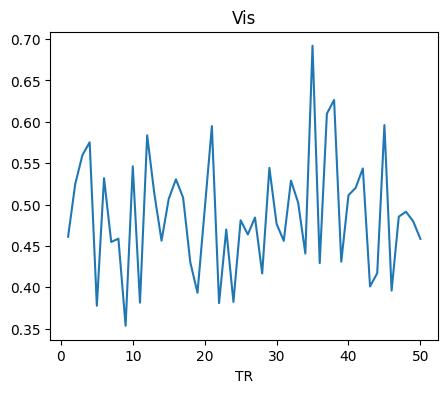

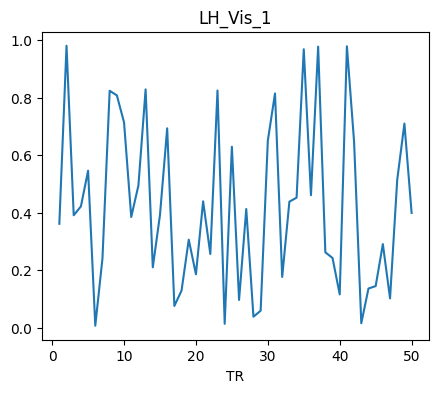

In [6]:
if ncol == 116:
    extractor.visualize_bold(subj_id="1", run=1, region="Cerebelum", figsize=(5,4))
    
    extractor.visualize_bold(subj_id="1", run=1, roi_indx=0, figsize=(5,4))
else:
    extractor.visualize_bold(subj_id="1", run=1, region="Vis", figsize=(5,4))

    extractor.visualize_bold(subj_id="1", run=1, roi_indx="LH_Vis_1", figsize=(5,4))

 <font size="3">Performing CAP analysis for two groups using the `groups` parameter when initializing the `CAP` class. Also finding the optimal cluster size for each group by using the elbow method. Additional options for `cluster_selection_method` includes the "silhouette", "davies_bouldin", and "variance_ratio". Additionally, visualizations from any method that produces them can be saved using `output_dir`, all methods have docstrings explaining their purpose, available parameters, kwargs, and properties (in the case of classes),</font>

2024-10-06 16:12:27,703 [INFO] [GROUP: High ADHD | METHOD: elbow] Optimal cluster size is 14.


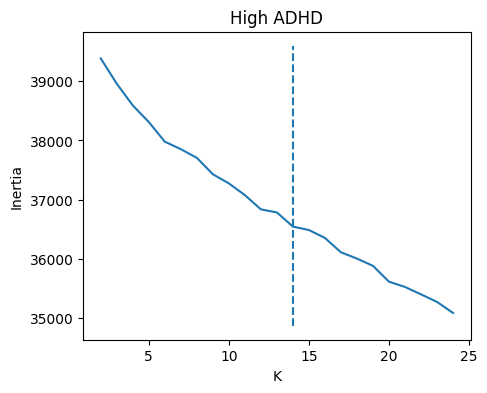

2024-10-06 16:12:28,746 [INFO] [GROUP: Low ADHD | METHOD: elbow] Optimal cluster size is 13.


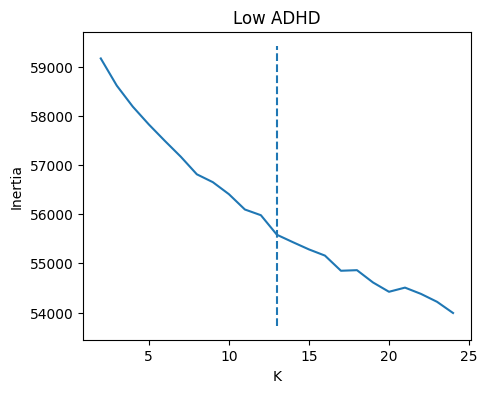

{'High ADHD': KMeans(max_iter=100, n_clusters=14, random_state=50), 'Low ADHD': KMeans(max_iter=100, n_clusters=13, random_state=50)}
{'High ADHD': 14, 'Low ADHD': 13}


In [7]:
cap_analysis = CAP(groups={"High ADHD": ["1","2","3","5"], "Low ADHD": ["4","6","7","8","9","10"]})

cap_analysis.get_caps(subject_timeseries=subject_timeseries,
                      runs=[1,2],
                      n_clusters=list(range(2, 25)), 
                      cluster_selection_method="elbow", 
                      show_figs=True,
                      random_state=50, 
                      max_iter=100, 
                      init="k-means++", 
                      n_cores=2, 
                      figsize=(5, 4))

print(cap_analysis.kmeans)
print(cap_analysis.optimal_n_clusters)

 <font size="3">Getting CAP metrics using the `calculate_metrics` method. Values assigned at NaN is just to indicate that a group does not have a particular CAP. This done to differentiate it from 0, which indicates a particular CAP did not appear in a subject. Note, all groups are in the same dataframe for simplicity but use their own kmeans models. Available metrics includes "counts", "temporal_fraction", "persistence", "transition_frequency", and "transition_probability" (as of version 0.16.2). </font>

In [8]:
# Show first 10 rows
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries)["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6,CAP-7,CAP-8,CAP-9,CAP-10,CAP-11,CAP-12,CAP-13,CAP-14
0,1,High_ADHD,run-1,1.00,1.142857,1.400000,1.000000,1.000000,1.00,1.000000,1.000000,1.125000,1.000000,1.00,0.000000,1.000000,1.000000
1,1,High_ADHD,run-2,0.00,1.000000,1.000000,1.250000,1.000000,1.50,1.333333,1.000000,1.250000,1.000000,1.00,1.000000,1.166667,1.333333
2,1,High_ADHD,run-3,1.00,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.25,1.000000,1.000000,1.666667
3,2,High_ADHD,run-1,1.00,1.142857,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,1.000000
4,2,High_ADHD,run-2,1.00,1.333333,1.111111,1.000000,1.000000,1.00,1.000000,1.000000,1.000000,2.000000,1.00,1.000000,1.000000,1.000000
5,2,High_ADHD,run-3,1.00,1.000000,1.285714,1.000000,1.000000,1.20,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,1.000000
6,3,High_ADHD,run-1,1.00,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.333333,1.000000,1.000000,1.00,1.000000,1.000000,1.000000
7,3,High_ADHD,run-2,1.00,1.000000,1.166667,1.333333,1.000000,1.25,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,1.000000
8,3,High_ADHD,run-3,1.00,1.000000,1.000000,1.000000,1.000000,1.25,1.000000,1.000000,1.250000,1.000000,0.00,1.400000,1.000000,1.000000
9,5,High_ADHD,run-1,1.00,1.000000,1.125000,1.333333,0.000000,1.00,1.000000,1.166667,1.333333,1.000000,1.00,1.000000,1.000000,1.000000


In [9]:
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries)["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6,CAP-7,CAP-8,CAP-9,CAP-10,CAP-11,CAP-12,CAP-13,CAP-14
0,1,High_ADHD,run-1,0.02,0.16,0.14,0.06,0.04,0.06,0.08,0.08,0.18,0.02,0.06,0.00,0.06,0.04
1,1,High_ADHD,run-2,0.00,0.04,0.04,0.10,0.04,0.12,0.08,0.10,0.10,0.02,0.04,0.10,0.14,0.08
2,1,High_ADHD,run-3,0.02,0.10,0.10,0.04,0.08,0.10,0.06,0.08,0.08,0.02,0.10,0.06,0.06,0.10
3,2,High_ADHD,run-1,0.06,0.16,0.10,0.04,0.04,0.10,0.02,0.08,0.12,0.02,0.02,0.06,0.14,0.04
4,2,High_ADHD,run-2,0.06,0.08,0.20,0.08,0.08,0.08,0.04,0.08,0.04,0.04,0.02,0.04,0.10,0.06
5,2,High_ADHD,run-3,0.04,0.06,0.18,0.08,0.02,0.12,0.06,0.04,0.08,0.06,0.06,0.04,0.10,0.06
6,3,High_ADHD,run-1,0.04,0.06,0.08,0.06,0.02,0.10,0.08,0.08,0.20,0.02,0.12,0.04,0.06,0.04
7,3,High_ADHD,run-2,0.02,0.12,0.14,0.08,0.04,0.10,0.02,0.12,0.02,0.08,0.06,0.10,0.02,0.08
8,3,High_ADHD,run-3,0.04,0.02,0.08,0.04,0.02,0.10,0.08,0.06,0.20,0.02,0.00,0.14,0.14,0.06
9,5,High_ADHD,run-1,0.04,0.10,0.18,0.08,0.00,0.08,0.02,0.14,0.08,0.06,0.08,0.08,0.04,0.02


In [10]:
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries)["counts"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6,CAP-7,CAP-8,CAP-9,CAP-10,CAP-11,CAP-12,CAP-13,CAP-14
0,1,High_ADHD,run-1,1,7,5,3,2,3,4,4,8,1,3,1,3,2.0
1,1,High_ADHD,run-2,1,2,2,4,2,4,3,5,4,1,2,5,6,3.0
2,1,High_ADHD,run-3,1,5,5,2,4,5,3,4,4,1,4,3,3,3.0
3,2,High_ADHD,run-1,3,7,5,2,2,5,1,4,6,1,1,3,7,2.0
4,2,High_ADHD,run-2,3,3,9,4,4,4,2,4,2,1,1,2,5,3.0
5,2,High_ADHD,run-3,2,3,7,4,1,5,3,2,4,3,3,2,5,3.0
6,3,High_ADHD,run-1,2,3,4,3,1,5,4,3,10,1,6,2,3,2.0
7,3,High_ADHD,run-2,1,6,6,3,2,4,1,6,1,4,3,5,1,4.0
8,3,High_ADHD,run-3,2,1,4,2,1,4,4,3,8,1,1,5,7,3.0
9,5,High_ADHD,run-1,2,5,8,3,1,4,1,6,3,3,4,4,2,1.0


 <font size="3">The `subject_table` property in the `CAP` class also acts has a setter and can be used to add an additional subject.</font>

In [11]:
subject_table = cap_analysis.subject_table
subject_table.update({"11": "High ADHD"})
cap_analysis.subject_table = subject_table
cap_analysis.subject_table

{'1': 'High ADHD',
 '2': 'High ADHD',
 '3': 'High ADHD',
 '5': 'High ADHD',
 '4': 'Low ADHD',
 '6': 'Low ADHD',
 '7': 'Low ADHD',
 '8': 'Low ADHD',
 '9': 'Low ADHD',
 '10': 'Low ADHD',
 '11': 'High ADHD'}

In [12]:
subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(50, ncol) for y in range(1, 4)} for x in range(1, 12)}

cap_analysis.calculate_metrics(subject_timeseries=subject_timeseries,
                               metrics=["temporal_fraction", "counts", "persistence", "transition_frequency"],
                               continuous_runs=True, tr=2)["counts"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6,CAP-7,CAP-8,CAP-9,CAP-10,CAP-11,CAP-12,CAP-13,CAP-14
0,1,High_ADHD,continuous_runs,3,13,24,13,3,12,14,10,9,3,11,10,14,3.0
1,2,High_ADHD,continuous_runs,4,10,22,10,5,20,5,13,13,4,8,8,12,4.0
2,3,High_ADHD,continuous_runs,5,8,23,4,8,14,4,9,22,5,9,8,14,5.0
3,5,High_ADHD,continuous_runs,4,17,19,8,5,10,11,7,19,4,7,13,11,7.0
4,4,Low_ADHD,continuous_runs,7,12,15,20,10,8,5,5,5,14,1,12,15,NaN
5,6,Low_ADHD,continuous_runs,4,17,16,22,18,5,5,11,6,10,2,4,16,NaN
6,7,Low_ADHD,continuous_runs,10,18,17,15,16,1,8,1,5,8,4,14,16,NaN
7,8,Low_ADHD,continuous_runs,9,14,12,19,10,4,8,5,3,23,4,9,16,NaN
8,9,Low_ADHD,continuous_runs,11,17,15,27,21,5,5,4,4,14,2,9,10,NaN
9,10,Low_ADHD,continuous_runs,4,11,16,22,15,4,6,5,6,19,3,11,14,NaN


 <font size="3">Using the the pickled subject timeseries as an input instead. All `subject_timeseries` parameters in the `neurocaps` class accepts pickles.</font>

2024-10-06 16:12:29,667 [INFO] [GROUP: High ADHD | METHOD: silhouette] Optimal cluster size is 2.


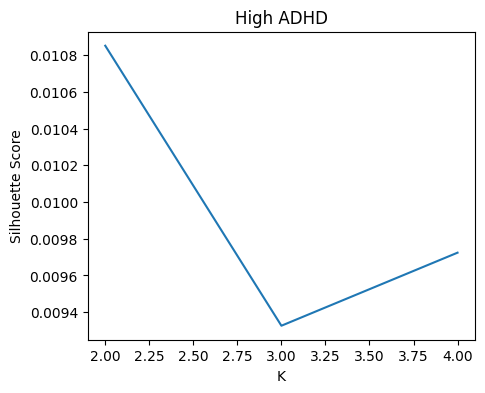

2024-10-06 16:12:30,145 [INFO] [GROUP: Low ADHD | METHOD: silhouette] Optimal cluster size is 2.


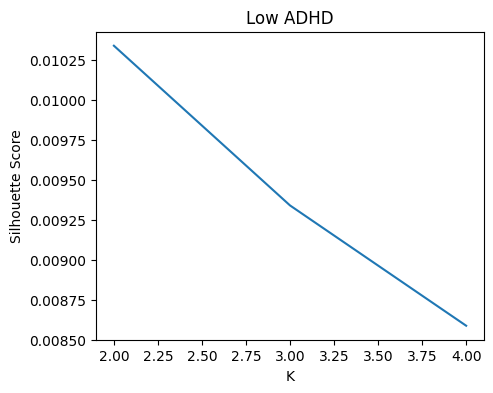

{'High ADHD': KMeans(n_clusters=2), 'Low ADHD': KMeans(n_clusters=2)}

In [13]:
cap_analysis.get_caps(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl",
                      n_clusters=list(range(2, 5)), 
                      cluster_selection_method="silhouette",
                      show_figs=True, 
                      figsize=(5, 4))

cap_analysis.kmeans

In [14]:
metrics = cap_analysis.calculate_metrics(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl",
                                         metrics="transition_probability", 
                                         continuous_runs=True)

print(metrics["transition_probability"])

{'High ADHD':   Subject_ID      Group              Run       1.1       1.2       2.1  \
0          1  High ADHD  continuous_runs  0.306122  0.693878  0.350000   
1          2  High ADHD  continuous_runs  0.396552  0.603448  0.395604   
2          3  High ADHD  continuous_runs  0.411765  0.588235  0.493827   
3          5  High ADHD  continuous_runs  0.423729  0.576271  0.366667   

        2.2  
0  0.650000  
1  0.604396  
2  0.506173  
3  0.633333  , 'Low ADHD':   Subject_ID     Group              Run       1.1       1.2       2.1  \
0          4  Low ADHD  continuous_runs  0.466667  0.533333  0.554054   
1          6  Low ADHD  continuous_runs  0.517241  0.482759  0.661290   
2          7  Low ADHD  continuous_runs  0.415385  0.584615  0.440476   
3          8  Low ADHD  continuous_runs  0.465753  0.534247  0.513158   
4          9  Low ADHD  continuous_runs  0.521127  0.478873  0.423077   
5         10  Low ADHD  continuous_runs  0.530120  0.469880  0.590909   

        2.2  
0  0.4

 <font size="3">`transition_matrix` can be used to generate and visualize the averaged transition probabilities for each group. </font>

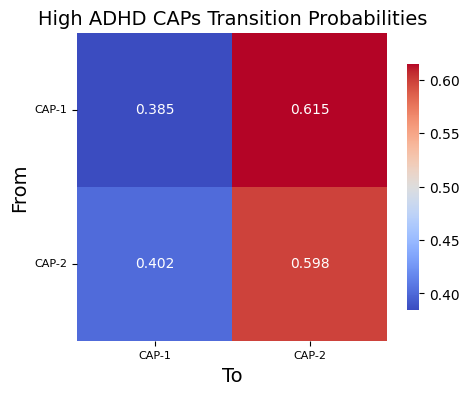

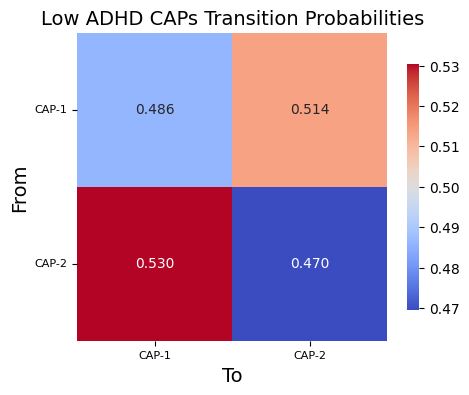

{'High ADHD':           CAP-1     CAP-2
 CAP-1  0.384542  0.615458
 CAP-2  0.401525  0.598475,
 'Low ADHD':           CAP-1     CAP-2
 CAP-1  0.486049  0.513951
 CAP-2  0.530494  0.469506}

In [15]:
from neurocaps.analysis import transition_matrix

transition_matrix(trans_dict=metrics["transition_probability"],
                  annot=True,
                  fmt=".3f", 
                  return_df=True, 
                  figsize=(5, 4))

In [16]:
cap_analysis.calculate_metrics(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl",
                               metrics="counts",
                               continuous_runs=True)

{'counts':   Subject_ID      Group              Run  CAP-1  CAP-2
 0          1  High_ADHD  continuous_runs     35     35
 1          2  High_ADHD  continuous_runs     36     36
 2          3  High_ADHD  continuous_runs     41     40
 3          5  High_ADHD  continuous_runs     34     34
 4          4   Low_ADHD  continuous_runs     41     41
 5          6   Low_ADHD  continuous_runs     42     42
 6          7   Low_ADHD  continuous_runs     38     38
 7          8   Low_ADHD  continuous_runs     40     39
 8          9   Low_ADHD  continuous_runs     34     34
 9         10   Low_ADHD  continuous_runs     39     40}

 <font size="3">`parcel_approach` can be during initialization of the `CAP` class or later when needed for visualization purposes. When setting the `parcel_approach` using the `self.parcel_approach` property pickles can be used to. This makes it easier if you are using a parcellation outside of Schaefer or AAL or you are using a modified version of these parcellations.</font>

In [17]:
cap_analysis.parcel_approach = parcel_approach

2024-10-06 16:12:30,600 [WARNING] 'yeo_networks' not specified in `parcel_approach`. Defaulting to 7 networks.
2024-10-06 16:12:30,601 [WARNING] 'resolution_mm' not specified in `parcel_approach`. Defaulting to 1mm.


 <font size="3">Visualizing CAPs as outer product heatmap at the regional/network level using `caps2plot` method.</font>

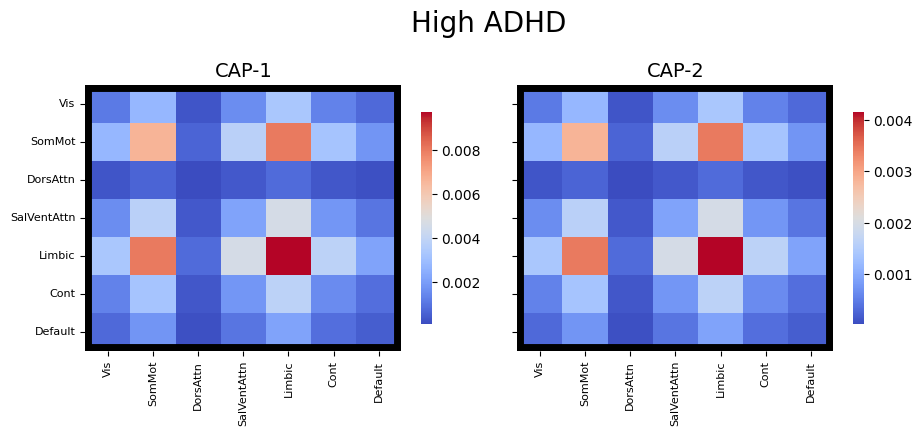

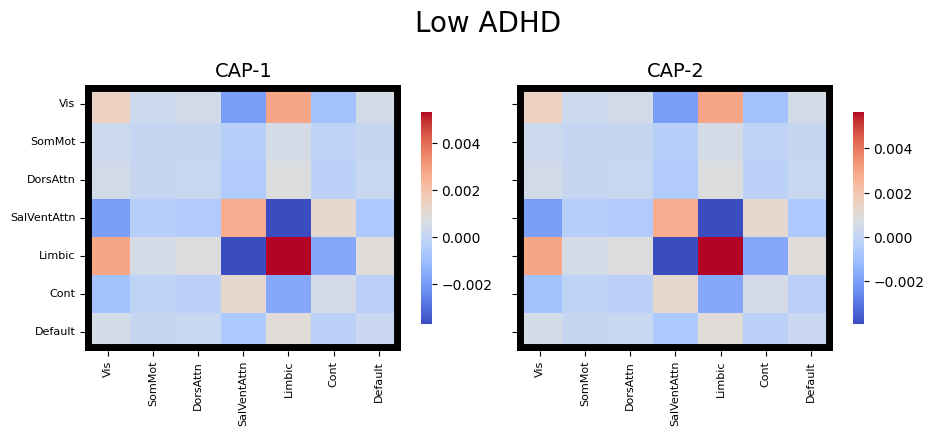

In [18]:
cap_analysis.caps2plot(subplots=True, xlabel_rotation=90, sharey=True, borderwidths=10, figsize=(9, 4))

 <font size="3">Visualizing CAPs as outer product heatmap at the node level using `caps2plot` method.</font>

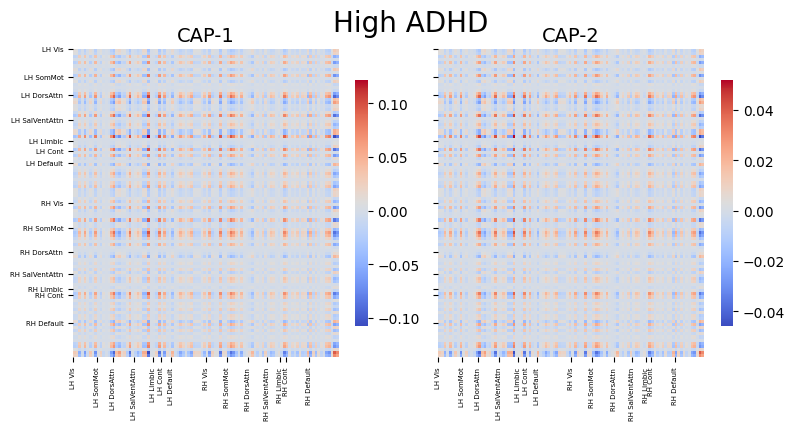

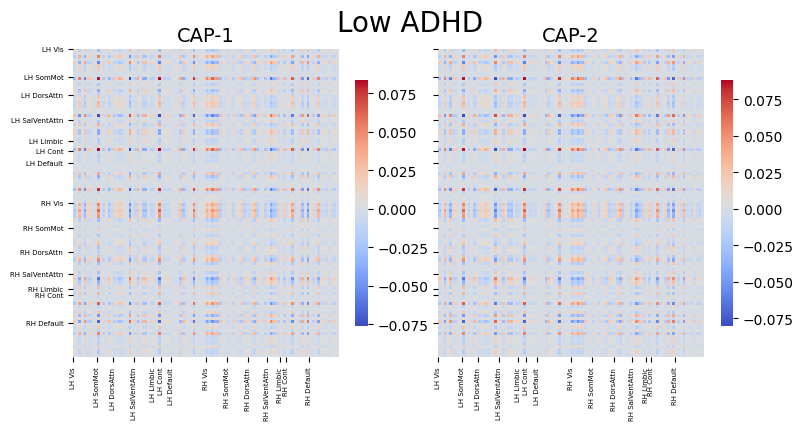

In [19]:
cap_analysis.caps2plot(yticklabels_size=5,
                       wspace=0.1,
                       subplots=True,
                       visual_scope="nodes",
                       xlabel_rotation=90,
                       xticklabels_size=5,
                       hspace=0.6,
                       tight_layout=False,
                       figsize=(9, 4))

 <font size="3">Visualizing CAPs as heatmaps at the regional level and using the `hemishere_labels` parameter to label the left and right hemispheres using `caps2plot` method.</font>

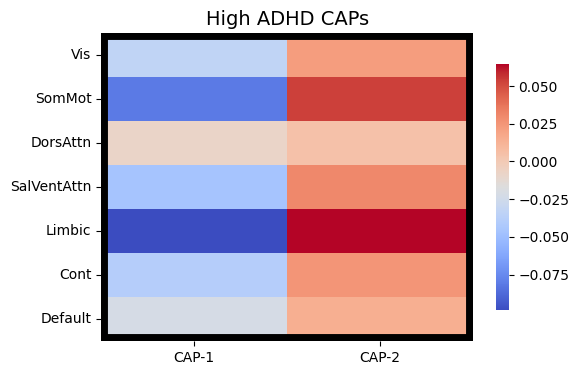

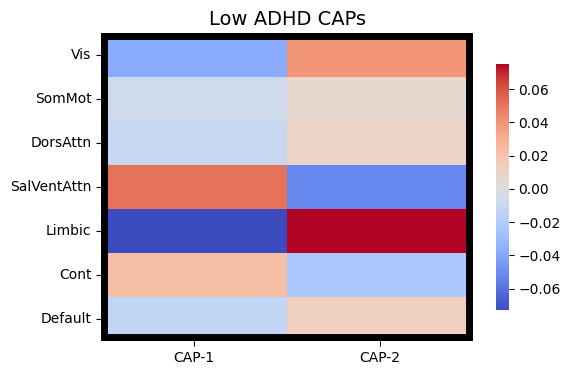

In [20]:
cap_analysis.caps2plot(subplots=True, visual_scope="regions", plot_options="heatmap", borderwidths=10, figsize=(6, 4))

 <font size="3">Using `merge_dicts` to merge common subjects across different subject timeseries dictionaries. This is to allow CAPs to be estimated on the merged dictionary (for similar CAPs across tasks or sessions) and for metrics to be calculated for each of the individual dictionaries. For instance, `subject_timeseries_1` may be the extracted timeseries from session 1 and `subject_timeseries_2` are the extracted timeseries for session 2. When merged, only subjects that have at least a single run across sessions will be returned in the merged dictionary. When `return_reduced_dicts` is True, only the subjects in the merged dictionary will be returned for the reduced dictionaries. In this example "dict_0" is the reduced form of `subject_timeseries_1` and "dict_1" is the reduced form of `subject_timeseries_2`. So, "merged" can be used as the input to estimate common CAPs across sessions for `get_caps` and "dict_0" and "dict_1" can be used as inputs for `calculate_metrics` to obtain the metrics for the CAPs for each session.</font>

In [21]:
# Individual plots. In the event you wnat to merge TRs from two dictionaries conatining the same subject to find common CAPs across a task
subject_timeseries_1 = {str(x) : {f"run-{y}": np.random.rand(100, ncol) for y in range(1, 4)} for x in range(1, 11)}
subject_timeseries_2 = {str(x) : {f"run-{y}": np.random.rand(100, ncol) for y in range(1, 4)} for x in range(1, 7)}

# Returns merged dictionary as well as the reduced subject dictionaries containing only the subjects present in the merged
all_dicts = merge_dicts(subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2],
                        return_merged_dict=True,
                        return_reduced_dicts=True)

print(all_dicts["dict_0"].keys())
print(all_dicts["dict_1"].keys())
print(all_dicts["merged"].keys())

dict_keys(['1', '2', '3', '4', '5', '6'])
dict_keys(['1', '2', '3', '4', '5', '6'])
dict_keys(['1', '2', '3', '4', '5', '6'])


 <font size="3">Generating examples not using the `group` parameter. When `group` is not defined, then the default group name is "All Subjects". Note, some additional plotting and non-plotting methods are shown below, all methods in the `CAP` class works regardless if `group` is None or defined since plots are generated for each group.</font>

In [22]:
cap_analysis = CAP(parcel_approach=extractor.parcel_approach)

cap_analysis.get_caps(subject_timeseries=all_dicts["merged"], n_clusters=3)

In [23]:
output = cap_analysis.calculate_metrics(subject_timeseries=all_dicts["dict_0"], return_df=True, runs=[1, 2])

output["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,1,All_Subjects,run-1,0.21,0.43,0.36
1,1,All_Subjects,run-2,0.36,0.30,0.34
2,2,All_Subjects,run-1,0.28,0.33,0.39
3,2,All_Subjects,run-2,0.35,0.29,0.36
4,3,All_Subjects,run-1,0.27,0.49,0.24
5,3,All_Subjects,run-2,0.32,0.45,0.23
6,4,All_Subjects,run-1,0.33,0.33,0.34
7,4,All_Subjects,run-2,0.38,0.30,0.32
8,5,All_Subjects,run-1,0.38,0.36,0.26
9,5,All_Subjects,run-2,0.39,0.36,0.25


In [24]:
output = cap_analysis.calculate_metrics(subject_timeseries=all_dicts["dict_1"],
                                        return_df=True,
                                        runs=[1, 2],
                                        continuous_runs=True)

output["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,1,All_Subjects,continuous_runs,1.183673,1.434783,1.551020
1,2,All_Subjects,continuous_runs,1.377778,1.312500,1.442308
2,3,All_Subjects,continuous_runs,1.725000,1.346939,1.625000
3,4,All_Subjects,continuous_runs,1.388889,1.437500,1.760870
4,5,All_Subjects,continuous_runs,1.568182,1.589744,1.769231
5,6,All_Subjects,continuous_runs,1.282609,1.619048,1.520833


In [25]:
output = cap_analysis.calculate_metrics(subject_timeseries=all_dicts["dict_1"], return_df=True, runs=[1, 2])

output["transition_frequency"]

,Subject_ID,Group,Run,Transition_Frequency
0,1,All_Subjects,run-1,72
1,1,All_Subjects,run-2,70
2,2,All_Subjects,run-1,76
3,2,All_Subjects,run-2,67
4,3,All_Subjects,run-1,63
5,3,All_Subjects,run-2,64
6,4,All_Subjects,run-1,63
7,4,All_Subjects,run-2,65
8,5,All_Subjects,run-1,63
9,5,All_Subjects,run-2,57


 <font size="3">Visualizing CAPs as outer product heatmap at the network level using `caps2plot` method with the `subplots` parameter set to True.</font>

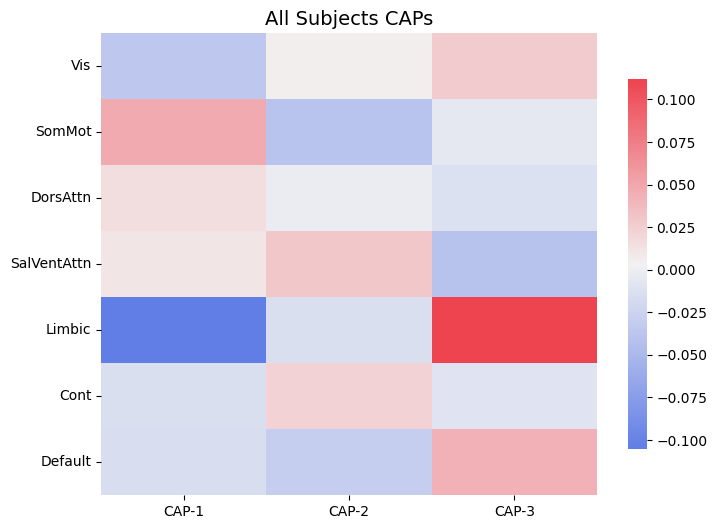

In [26]:
import seaborn as sns

sns.diverging_palette(145, 300, s=60, as_cmap=True)

palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)

cap_analysis.caps2plot(visual_scope="regions",
                       plot_options="heatmap", 
                       subplots=True, 
                       fontsize=14, 
                       ncol=6,
                       sharey=False, 
                       tight_layout=False, 
                       xlabel_rotation=0, 
                       hspace = 0.3, 
                       cmap=palette)

`caps2corr` can be used to obtain the Pearson correlation between CAPs and to obtain a dataframe of the uncorrected p-values.

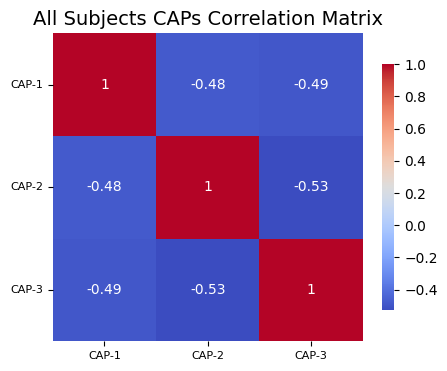

,CAP-1,CAP-2,CAP-3
CAP-1,1 (0)***,-0.48 (4.5e-07)***,-0.49 (2.1e-07)***
CAP-2,-0.48 (4.5e-07)***,1 (0)***,-0.53 (1.6e-08)***
CAP-3,-0.49 (2.1e-07)***,-0.53 (1.6e-08)***,1 (0)***


In [27]:
corr_df = cap_analysis.caps2corr(annot=True, figsize=(5,4), return_df=True)
corr_df["All Subjects"]

 <font size="3">Visualizing CAPs as surface plots using `caps2surf` method.</font>

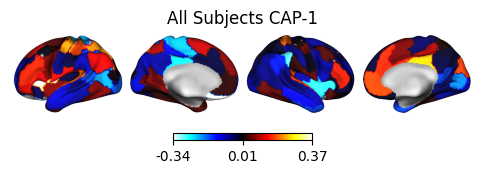

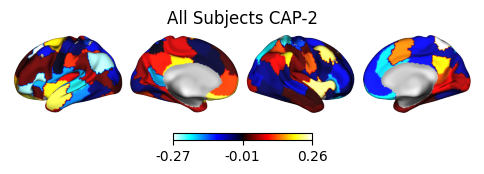

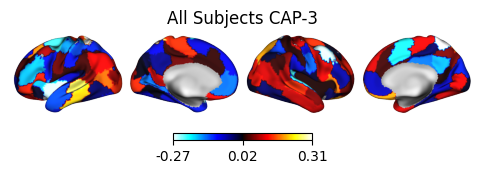

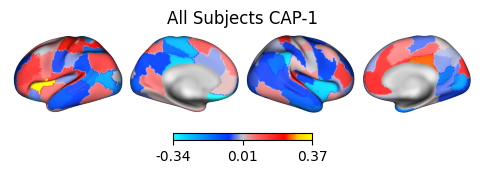

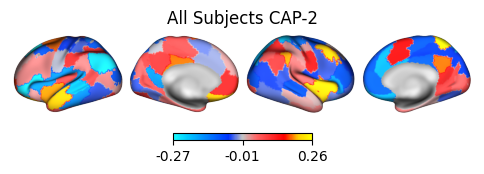

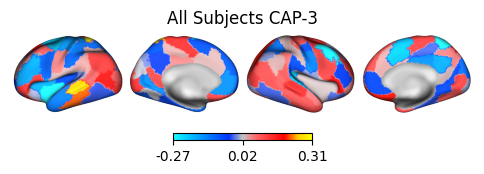

In [28]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["#1bfffe", "#00ccff", "#0099ff", "#0066ff", "#0033ff",
          "#c4c4c4", "#ff6666", "#ff3333", "#FF0000","#ffcc00",
          "#FFFF00"]

cap_analysis.caps2surf(cmap="cold_hot", layout="row",  size=(500, 100))

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)

cap_analysis.caps2surf(cmap=custom_cmap, size=(500, 100), layout="row", surface="veryinflated")

 <font size="3">CAPs can also be projected onto the parcellation and saved as NifTI files. These same files can also be saved when using `caps2surf`. Additionally, this function also has the `knn_dict` parameter.</font>

In [29]:
cap_analysis.caps2niftis(output_dir=output_dir, suffix_file_name="for_neurocaps_demo")

 <font size="3">Radar plots showing the cosine similarity between each network and the positive ("High Amplitude") and negative ("Low Amplitude") activations in each CAP. The cosine similarities are stored in the `self.cosine_similarity` property.</font>

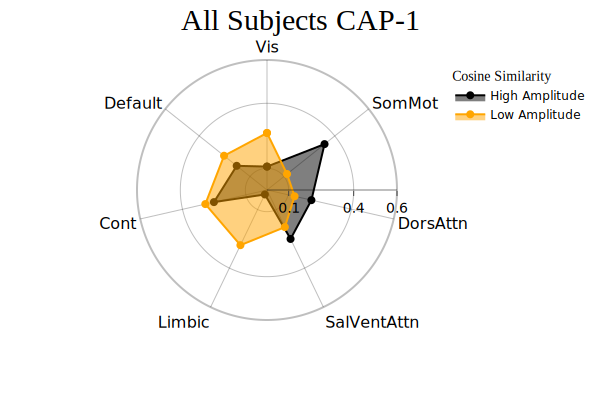

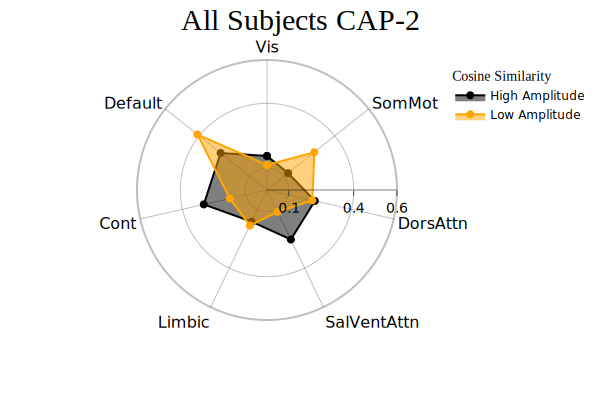

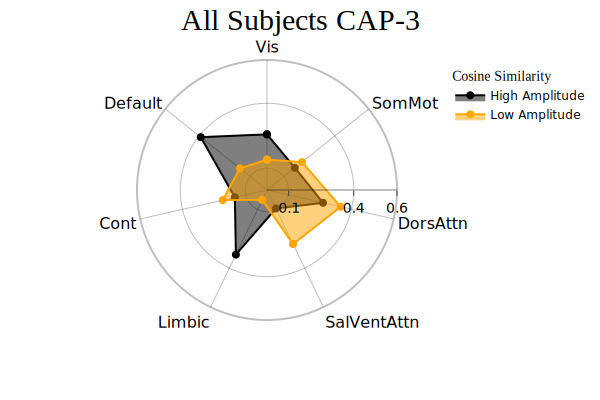

In [30]:
radialaxis={"showline": True, 
            "linewidth": 2, 
            "linecolor": "rgba(0, 0, 0, 0.25)", 
            "gridcolor": "rgba(0, 0, 0, 0.25)",
            "ticks": "outside" , 
            "tickfont": {"size": 14, "color": "black"}, 
            "range": [0, 0.6],
            "tickvals": [0.1, "", "", 0.4, "", "", 0.6]}

legend = {"yanchor": "top", 
          "y": 0.99, 
          "x": 0.99,
          "title_font_family": "Times New Roman", 
          "font": {"size": 12, "color": "black"}}

colors =  {"High Amplitude": "black", "Low Amplitude": "orange"}

cap_analysis.caps2radar(radialaxis=radialaxis, 
                        fill="toself", 
                        height=400, 
                        width=600,
                        color_discrete_map = colors,
                        legend=legend)

In [31]:
import pandas as pd

df = pd.DataFrame(cap_analysis.cosine_similarity["All Subjects"]["CAP-1"])
df["Regions"] = cap_analysis.cosine_similarity["All Subjects"]["Regions"]
print(df)

   High Amplitude  Low Amplitude      Regions
0        0.108086       0.263242          Vis
1        0.339687       0.118275       SomMot
2        0.210241       0.130495     DorsAttn
3        0.250751       0.189995  SalVentAttn
4        0.022807       0.282645       Limbic
5        0.251214       0.292019         Cont
6        0.178888       0.253514      Default


 <font size="3">The neurocaps package uses nilearn to obtain the "maps" and "nodes" for the Schaefer and AAL atlases, then uses some Python code to create a list of "regions" using the "nodes" list. Neurocaps can also accept additional parcellations (as long as they are lateralized since the current iteration of the codebase assumes an "lh" and "rh" key for each region but this may be changed in a future update. Below is an example using the HCPex atlas from [wayalan Github](https://github.com/wayalan/HCPex/) for the `CAP` class.</font>

In [32]:
import subprocess

# First, retrieve the map and labels from wayalan Github
os.makedirs("neurocaps_demo",exist_ok=True)

target_dir = os.path.abspath('')

if sys.platform != "win32":
    cmd = [
        ["wget", "-q", "-P", f"{target_dir}/neurocaps_demo", 
        "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex_LookUpTable.txt"],
        ["wget",  "-q", "-P", f"{target_dir}/neurocaps_demo", 
        "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex.nii.gz"]
    ]
else:
    cmd = [
        ["curl", "-L", "-o", f"{target_dir}\\neurocaps_demo\\HCPex_LookUpTable.txt", 
        "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex_LookUpTable.txt"],
        ["curl", "-L", "-o", f"{target_dir}\\neurocaps_demo\\HCPex.nii.gz", 
        "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex.nii.gz"]
    ]
    
for command in cmd: subprocess.run(command, check=True)

# Creating custom parcel approach dictionary
parcel_approach = {"Custom": {}}

# Setting the "maps"; this is needed for `TimeseriesExtractore.get_bold()` and `CAP.caps2niftis` and `CAP.cap2surf`
parcel_approach["Custom"]["maps"] = os.path.join(f"{target_dir}","neurocaps_demo","HCPex.nii.gz")

# Setting the "nodes"; needed for "TimeseriesExtractor.visualize_bold"; Getting nodes that don't correspond to background label
parcel_approach["Custom"]["nodes"] = pd.read_csv(os.path.join(f"{target_dir}","neurocaps_demo", "HCPex_LookUpTable.txt"), sep=None)["Label"].values[1:]

# Needed for many plotting methods; Setting the region names and their corresponding indices in the nodes list, in this case it is just the label id - 1
parcel_approach["Custom"]["regions"]  = {
    "Primary Visual": {"lh": [0], "rh": [180]},
    "Early Visual": {"lh": [1, 2, 3], "rh": [181, 182, 183]},
    "Dorsal Stream Visual": {"lh": list(range(4, 10)), "rh": list(range(184, 190))},
    "Ventral Stream Visual": {"lh": list(range(10, 17)), "rh": list(range(190, 197))},
    "MT+ Complex": {"lh": list(range(17, 26)), "rh": list(range(197, 206))},
    "SomaSens Motor": {"lh": list(range(26, 31)), "rh": list(range(206, 211))},
    "ParaCentral MidCing": {"lh": list(range(31, 40)), "rh": list(range(211, 220))},
    "Premotor": {"lh": list(range(40, 47)), "rh": list(range(220, 227))},
    "Posterior Opercular": {"lh": list(range(47, 52)), "rh": list(range(227, 232))},
    "Early Auditory": {"lh": list(range(52, 59)), "rh": list(range(232, 239))},
    "Auditory Association": {"lh": list(range(59, 67)), "rh": list(range(239, 247))},
    "Insula FrontalOperc": {"lh": list(range(67, 79)), "rh": list(range(247, 259))},
    "Medial Temporal": {"lh": list(range(79, 87)), "rh": list(range(259, 267))},
    "Lateral Temporal": {"lh": list(range(87, 95)), "rh": list(range(267, 275))},
    "TPO": {"lh": list(range(95, 100)), "rh": list(range(275, 280))},
    "Superior Parietal": {"lh": list(range(100, 110)), "rh": list(range(280, 290))},
    "Inferior Parietal": {"lh": list(range(110, 120)), "rh": list(range(290, 300))},
    "Posterior Cingulate": {"lh": list(range(120, 133)), "rh": list(range(300, 313))},
    "AntCing MedPFC": {"lh": list(range(133, 149)), "rh": list(range(313, 329))},
    "OrbPolaFrontal": {"lh": list(range(149, 158)), "rh": list(range(329, 338))},
    "Inferior Frontal": {"lh": list(range(158, 167)), "rh": list(range(338, 347))},
    "Dorsolateral Prefrontal": {"lh": list(range(167, 180)), "rh": list(range(347, 360))},
    "Subcortical Regions": {"lh": list(range(360, 393)), "rh": list(range(393, 426))}
}

# Saving the dictionary as a pickle file
with open(f"{os.path.join(target_dir,'neurocaps_demo', 'HCPex_dict.pkl')}", "wb") as f:
    joblib.dump(parcel_approach, f)

/tmp/ipykernel_211999/3510947882.py:32: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.



<font size="3">For "Custom" parcel approaches, all visualization methods can be used.

In [33]:
# Creating new subject timeseries that has 426 columns
subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(50, 426) for y in range(1, 4)} for x in range(1, 11)}

cap_analysis = CAP(parcel_approach=os.path.join(target_dir, "neurocaps_demo", "HCPex_dict.pkl"))

cap_analysis.get_caps(subject_timeseries=subject_timeseries,
                      cluster_selection_method="variance_ratio", 
                      n_clusters=list(range(2, 11)))

# The `parcel_approach`` can be set using the dictionary format when initializing the `CAP`` class or using the `parcel_approach`` property as a setter
# cap_analysis.parcel_approach = parcel_approach
# cap_analysis.parcel_approach = os.path.join(target_dir,"neurocaps_demo", "HCPex_dict.pkl")

2024-10-06 16:13:03,817 [INFO] [GROUP: All Subjects | METHOD: variance_ratio] Optimal cluster size is 2.


<font size="3">This is primarily for parcellations outside of Schaefer and AAL. If you notice that your surface plots are sparse due to having many unassigned cortical surface voxels, there is a `knn_dict` parameter in both `caps2surf` and `caps2niftis`, which uses the Schaefer atlas as a reference atlas to determine the background boundaries so that k-nearest neighbors interpolation can be used. The sub-keys are "k" and "resolution_mm" for the resolution of Schaefer to use as the reference.</font>

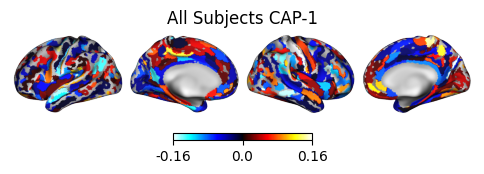

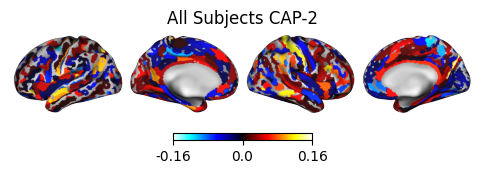

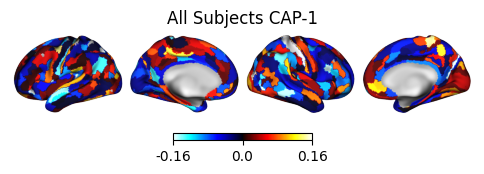

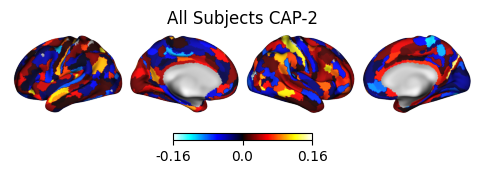

In [34]:
# Plotting with caps2surf; showing original and version using knn to reduce gaps
cap_analysis.caps2surf(size=(500, 100),
                       layout="row", 
                       method="nearest", 
                       color_range=[-0.16,0.16])

cap_analysis.caps2surf(size=(500, 100), 
                       layout="row", 
                       method="nearest",
                       knn_dict={"k": 5, "resolution_mm": 1},
                       color_range=[-0.16,0.16],
                       save_stat_maps=True,
                       output_dir=os.path.join(target_dir, "neurocaps_demo"))

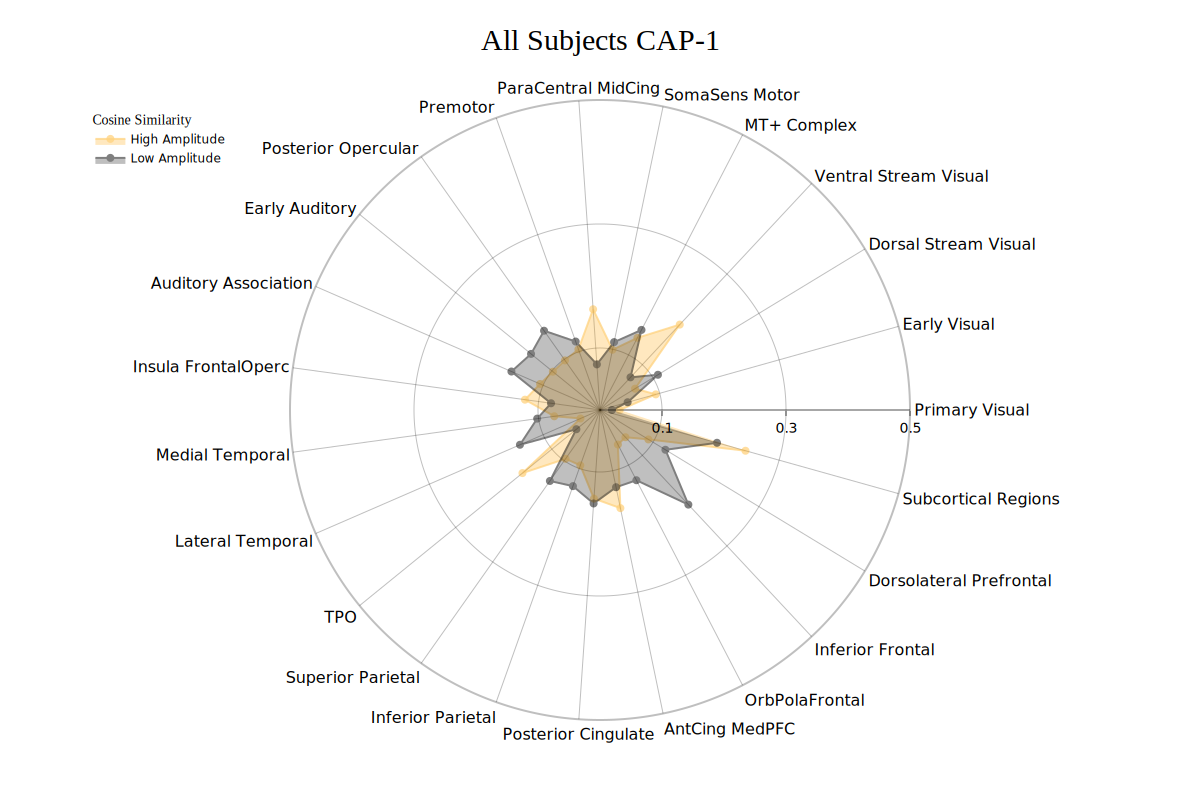

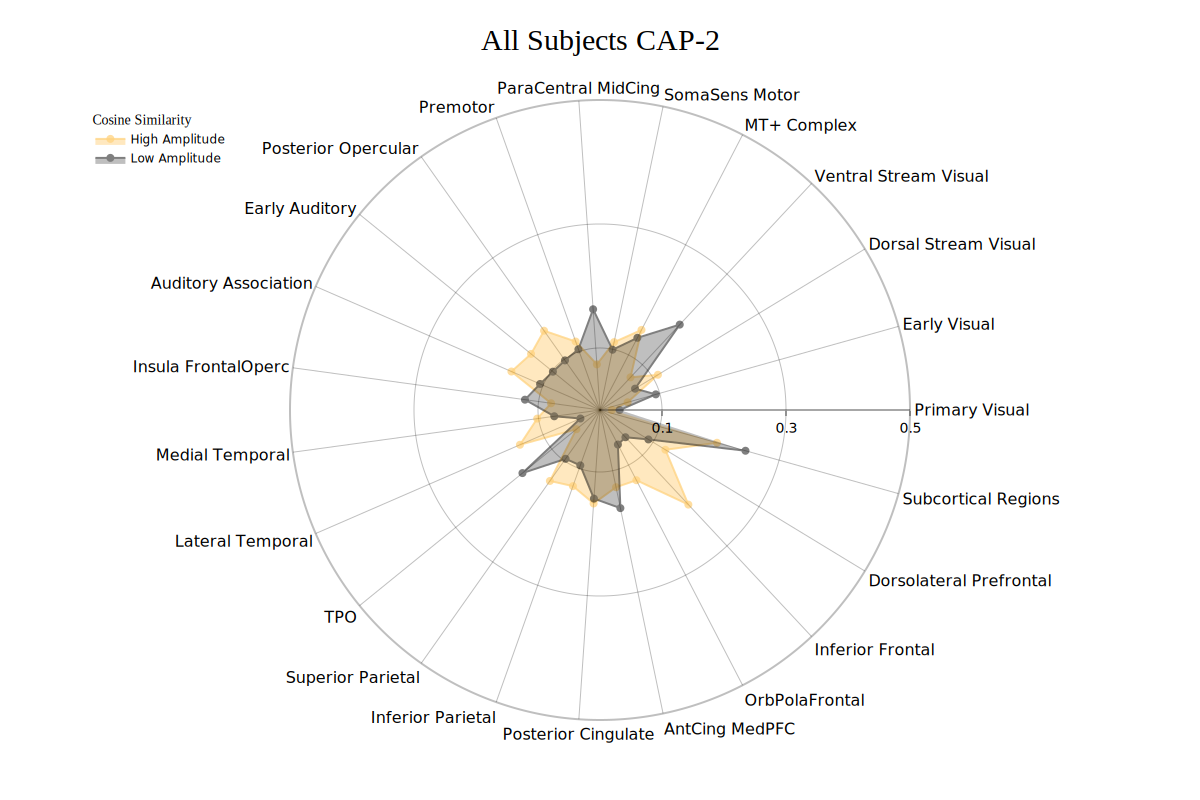

In [35]:
radialaxis={"showline": True,
            "linewidth": 2, 
            "linecolor": "rgba(0, 0, 0, 0.25)", 
            "gridcolor": "rgba(0, 0, 0, 0.25)",
            "ticks": "outside" , 
            "tickfont": {"size": 14, "color": "black"},
            "range": [0, 0.5],
            "tickvals": [0.1, "", 0.3, "", 0.5]}

color_discrete_map = {"High Amplitude": "rgba(255, 165, 0, 0.75)", "Low Amplitude": "black"}

cap_analysis.caps2radar(radialaxis=radialaxis, 
                        fill="toself",
                        color_discrete_map=color_discrete_map, 
                        use_scatterpolar=True,
                        output_dir=os.path.join(target_dir, "neurocaps_demo"),
                        as_html=True)

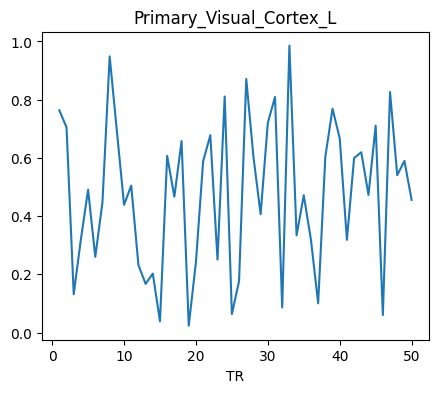

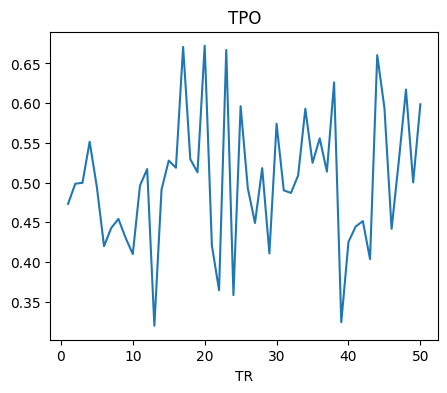

In [36]:
extractor.parcel_approach = os.path.join(target_dir,"neurocaps_demo", "HCPex_dict.pkl") 

# Can also just set it
# extractor = TimeseriesExtractor(parcel_approach=os.path.join(target_dir,"neurocaps_demo", "HCPex_dict.pkl"))

# Subject timeseries also acts as a setter if the `visualize_bold` method needs to be used
extractor.subject_timeseries = subject_timeseries

with open("sample_for_neurocaps_demo_timeseries_HCPex.pkl", "wb") as f:
    joblib.dump(subject_timeseries, f)

extractor.subject_timeseries = "sample_for_neurocaps_demo_timeseries_HCPex.pkl"

extractor.visualize_bold(subj_id="1",
                         run=1, 
                         roi_indx=0,
                         figsize=(5, 4), 
                         output_dir=os.path.join(target_dir,"neurocaps_demo"),
                         file_name="test_bold_for_neurocaps")

extractor.visualize_bold(subj_id="1", run=1, region="TPO", figsize=(5,4))

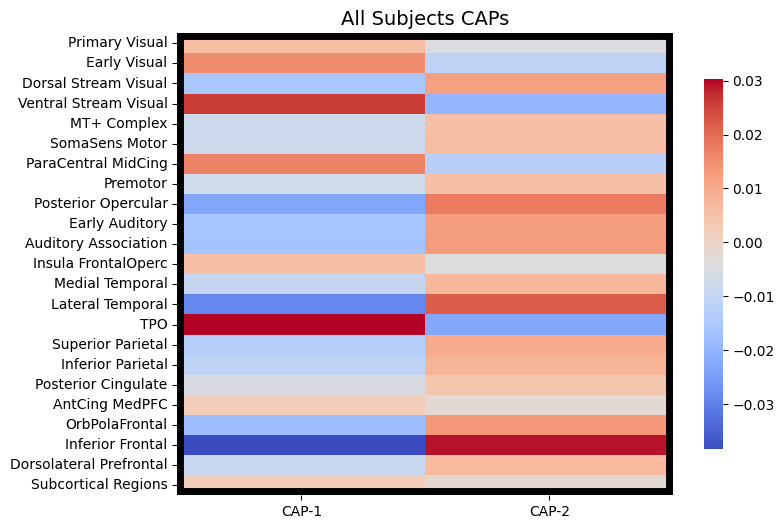

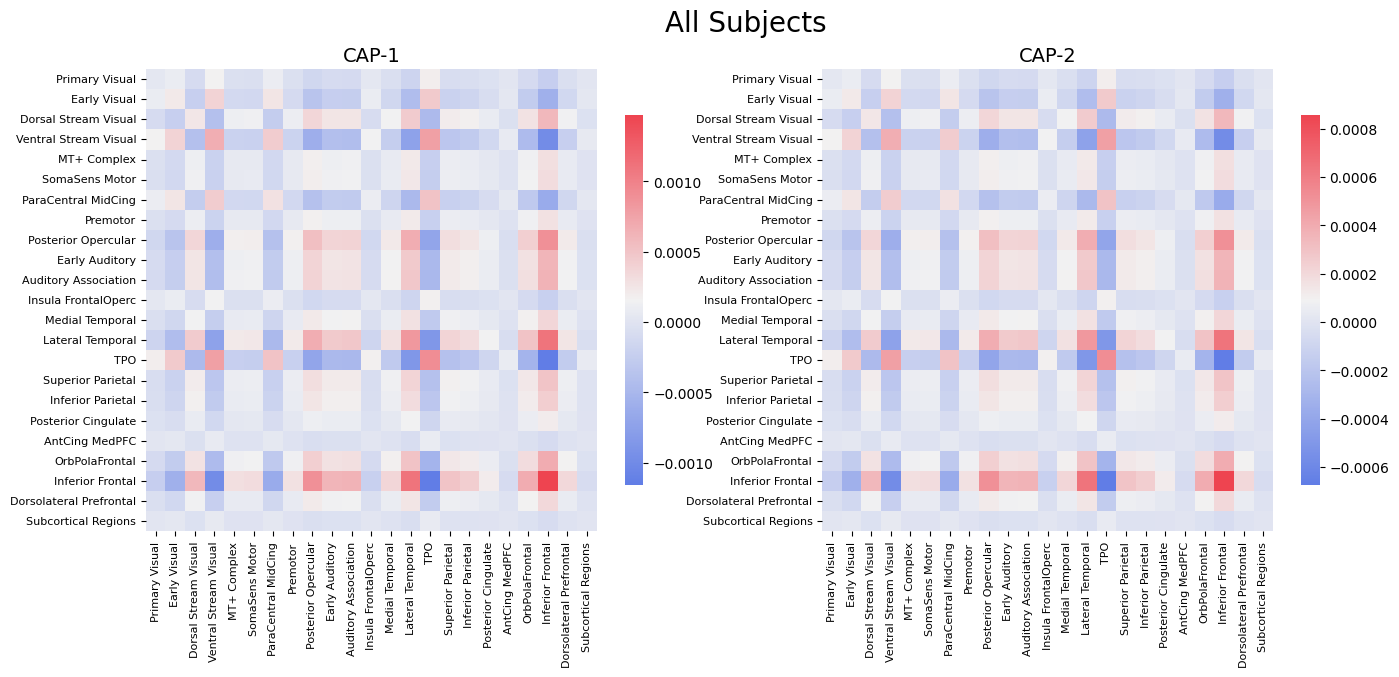

In [37]:
cap_analysis.caps2plot(subplots=True, visual_scope="regions", plot_options="heatmap", borderwidths=10)

cap_analysis.caps2plot(visual_scope="regions",
                       plot_options="outer_product",
                       subplots=True, 
                       fontsize=14, 
                       ncol=6,
                       sharey=False, 
                       tight_layout=False, 
                       xlabel_rotation=90, 
                       hspace = 0.3, 
                       cmap=palette,
                       output_dir=os.path.join(target_dir, "neurocaps_demo"))


 <font size="3">`caps2corr` only depends on the CAPs and `calculate_metrics` only depends on the timeseries.</font>

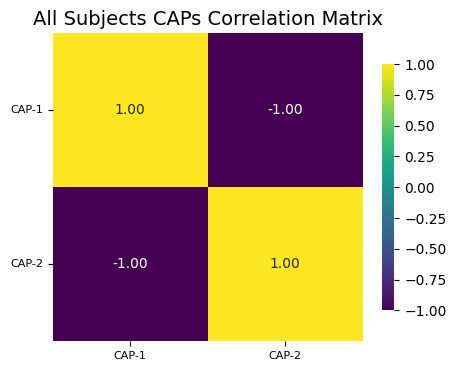

,Subject_ID,Group,Run,CAP-1,CAP-2
0,1,All_Subjects,continuous_runs,3.939394,5.151515
1,2,All_Subjects,continuous_runs,3.560976,3.756098
2,3,All_Subjects,continuous_runs,3.684211,4.324324
3,4,All_Subjects,continuous_runs,3.150000,4.350000
4,5,All_Subjects,continuous_runs,3.771429,4.800000
5,6,All_Subjects,continuous_runs,3.209302,3.857143
6,7,All_Subjects,continuous_runs,3.771429,4.800000
7,8,All_Subjects,continuous_runs,3.812500,5.562500
8,9,All_Subjects,continuous_runs,2.777778,5.555556
9,10,All_Subjects,continuous_runs,3.666667,4.540541


In [38]:
cap_analysis.caps2corr(annot=True, 
                       cmap="viridis", 
                       fmt=".2f", 
                       figsize=(5, 4), 
                       output_dir=os.path.join(target_dir,"neurocaps_demo"))

outputs = cap_analysis.calculate_metrics(subject_timeseries="sample_for_neurocaps_demo_timeseries_HCPex.pkl",
                                         tr=2,
                                         continuous_runs=True,
                                         metrics=["persistence", "transition_probability"],
                                         output_dir=os.path.join(target_dir, "neurocaps_demo"))
outputs["persistence"]

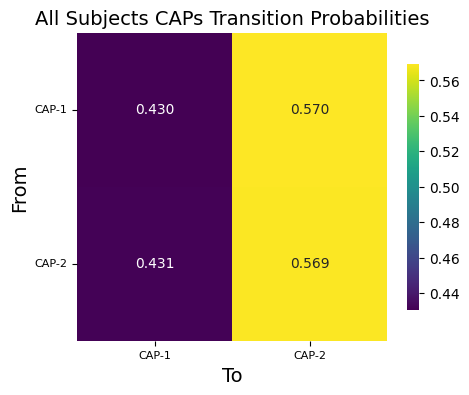

{'All Subjects':           CAP-1     CAP-2
 CAP-1  0.430433  0.569567
 CAP-2  0.431391  0.568609}

In [39]:
transition_matrix(trans_dict=outputs["transition_probability"],
                  annot=True,
                  fmt=".3f",
                  return_df=True, 
                  figsize=(5, 4),
                  cmap="viridis")

 <font size="3">Removes the files and directories generated in this demo.</font>

In [40]:
os.remove("sample_for_neurocaps_demo_timeseries.pkl")

os.remove("sample_for_neurocaps_demo_timeseries_HCPex.pkl")

[os.remove(x) for x in ["All_Subjects_CAP-1_for_neurocaps_demo.nii.gz",
"All_Subjects_CAP-2_for_neurocaps_demo.nii.gz", "All_Subjects_CAP-3_for_neurocaps_demo.nii.gz"]]

import shutil

shutil.rmtree("neurocaps_demo", ignore_errors=True)